# Autoencoders

Autoencoders are a special type of neural networks that are trained to copy its input to its output. In other words, they try to learn the function $f$, such that $f(x)=x$, i.e., to reproduce their input $x$. Such networks consist of two parts: an `encoder` and a `decoder`.

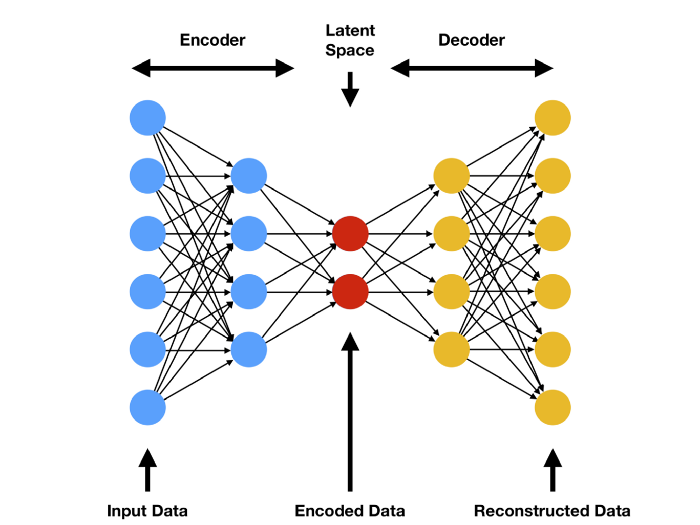

The `encoder` is a part of the network that maps the input of dimension $A$ into a vector of dimension $B$, where it is true that $A>B$, i.e., the dimensionality is reduced. A vector of dimension $B$ is called a vector of latent space of dimension $B$.

The `decoder` maps the obtained vector of dimension $B$ into the initial vector of dimension $A$, i.e., it reconstructs the input based on the vector from the latent space.

Autoencoder training is performed as training a standard neural network in classification and regression problems. What interests us most in working with them is the latent space and representations of the inputs, which are usually significantly smaller in size. For example, when working with text, we can use trained `GloVe` and `Word2Vec` representations obtained by training specific autoencoders.

The following example, however, shows a slightly different scenario of applying a **Denoising Autoencoder** to an image processing task.

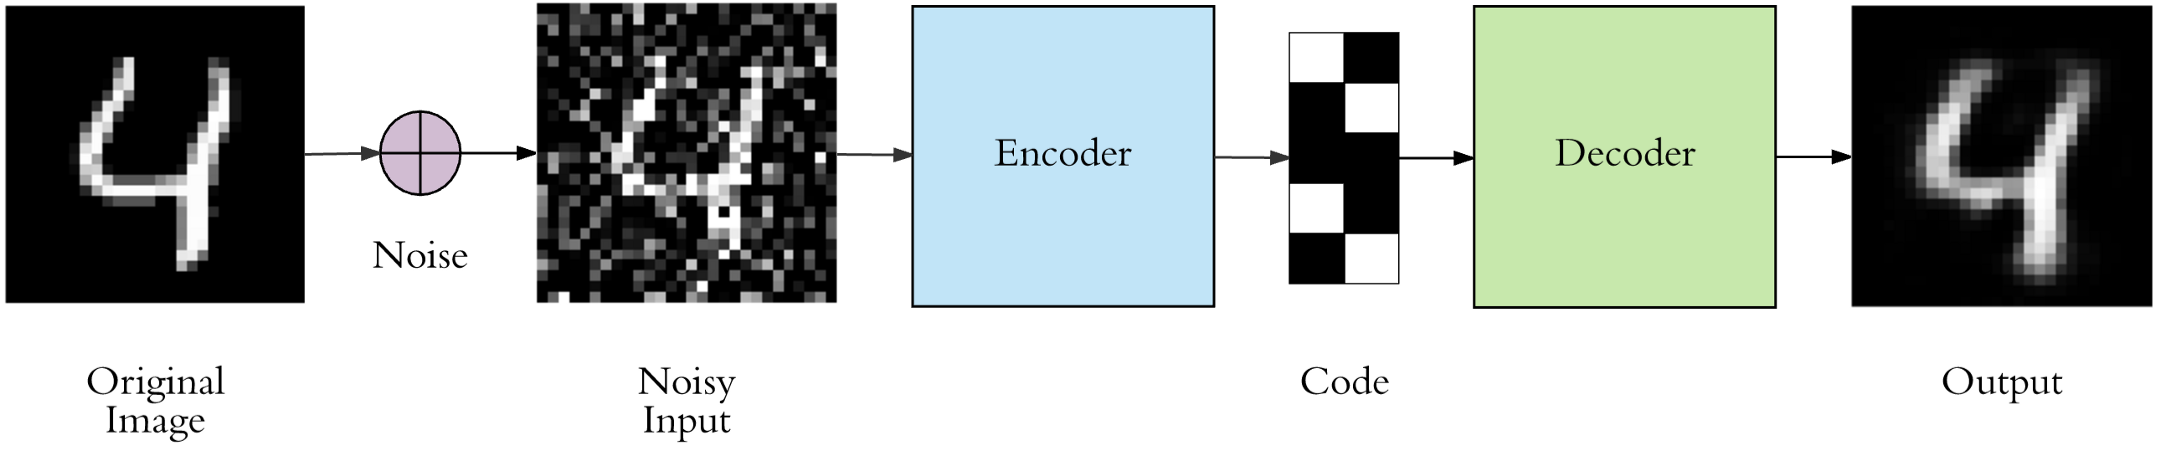

In [1]:
import tensorflow as tf
from tensorflow import keras

2022-12-24 12:09:33.927033: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-24 12:09:34.110373: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-24 12:09:34.110395: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-24 12:09:35.257658: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

In [4]:
np.random.seed(1337)

First we will load the dataset. The labels themselves that are associated with the instances are not important for autoencoders.

In [5]:
(X_train, _), (X_test, _) = mnist.load_data()

The images we work with are of size $28\times 28$ and we will prepare them by correcting them and normalizing their values. In addition to this, we will add an additional dimension to the images with a value of $1$ which represents their channel (the images are black and white).

In [6]:
image_size = X_train.shape[1]
print(image_size)

28


In [7]:
X_train = np.reshape(X_train, (-1, image_size, image_size, 1))
X_train = X_train.astype('float32') / 255

X_test = np.reshape(X_test, (-1, image_size, image_size, 1))
X_test = X_test.astype('float32') / 255

In [8]:
X_train.shape

(60000, 28, 28, 1)

In [9]:
X_test.shape

(10000, 28, 28, 1)

Next, we will generate noise from the normal $\mathcal{N}(0.5,0.5)$ distribution, which will be added to the images.

In [10]:
noise = np.random.normal(loc=0.5, scale=0.5, size=X_train.shape)
X_train_noisy = X_train + noise

noise = np.random.normal(loc=0.5, scale=0.5, size=X_test.shape)
X_test_noisy = X_test + noise

# We will cut off the values that fell out of the range [0,1] after adding the noise
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

We will show, for example, 9 modified images obtained this way.

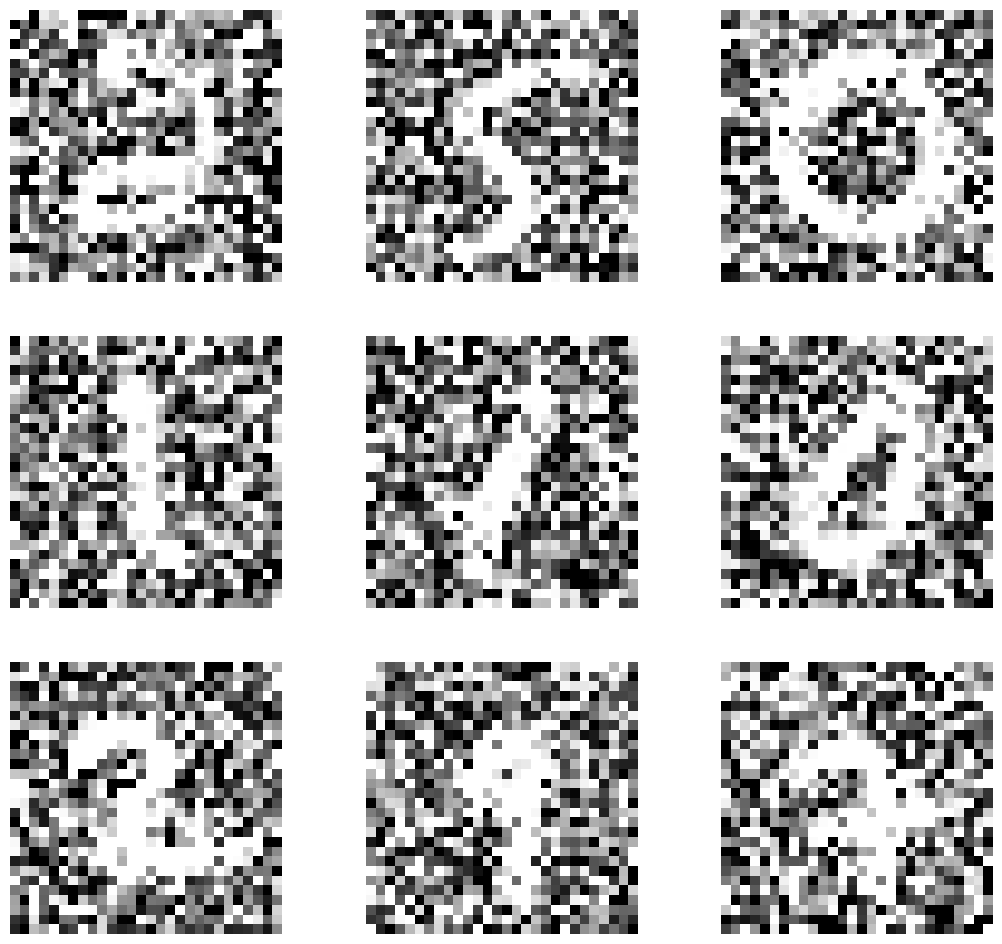

In [11]:
nrows = 3
ncols = 3

# We prepare a panel for drawing each of the images
fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(13, 12)

# We extract nrows*ncols images at random
ix = np.random.randint(low=0, high=X_train_noisy.shape[0], size=nrows*ncols)
chosen_imgs = X_train_noisy[ix]

# We plot each image separately
i = 0
for row in ax:
    for col in row:
        # Before displaying them we change the dimension of each image from (image_size,image_size,1)
        # to (image_size, image_size) as this is required by matplotlib
        img = chosen_imgs[i].reshape(image_size, image_size)
        col.imshow(img, cmap='gray')
        col.axis('off')
        i += 1
        
plt.show()       

Next we will define the network parameters. The input to the network is a tensor of the form $(28, 28, 1)$ where $28\times 28$ is the dimension of the image, and $1$ is an indication that there is $1$ image channel because the images are black and white. We will map those images to vectors of dimension $16$.

In [12]:
input_shape = (image_size, image_size, 1)
latent_dim = 16

## Encoder

The encoder will be a convolutional network that maps the tensors of dimension $(28, 28, 1)$ into a vector of dimension $16$.

In [13]:
# Kernel size
kernel_size = 3

# Number of filters in convolutional layers
layer_filters = [32, 64]

We will use the functional API of the Keras library to create the network.

In [14]:
# We have the input layer
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# Afterwards we have two convolutional layers
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# We will read and preserve the dimensions of the tensor to obtain
# (None, 7, 7, 64) 
shape = K.int_shape(x)

# Then we have a flattening layer
x = Flatten()(x)

# and then the dense layer that generates the latent representation
latent_outputs = Dense(latent_dim, name='latent_vector')(x)

encoder = Model(inputs=inputs, outputs=latent_outputs, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 16)                50192     
                                                                 
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


2022-12-24 12:11:30.610625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-24 12:11:30.610755: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-24 12:11:30.610818: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-24 12:11:30.610869: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-24 12:11:30.610917: W tensorf

## Decoder

The decoder will be a convolutional neural network that maps a vector of dimension $16$ into a tensor of dimension $(28,28,1)$.

In [15]:
# Kernel size
kernel_size = 3

# Number of filters in convolutional layers
layer_filters = [32, 64]

In [16]:
# First we have the input layer
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')

# afterwards we have one dense layer that allows us to 
# transform the input into (None, 7, 7, 64)
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# then we add transposed convolutional layers but in a reversed order compared to the encoder
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                    kernel_size=kernel_size,
                    strides=2,
                    activation='relu',
                    padding='same')(x)

# then we add one more convolutional layer to control the channel dimension   
x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

# and one activation later with the sigmoid activation function
outputs = Activation('sigmoid', name='decoder_output')(x)

decoder = Model(inputs=latent_inputs, outputs=outputs, name='decoder')
decoder.summary(line_length=110)

Model: "decoder"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 decoder_input (InputLayer)                      [(None, 16)]                                0                
                                                                                                              
 dense (Dense)                                   (None, 3136)                                53312            
                                                                                                              
 reshape (Reshape)                               (None, 7, 7, 64)                            0                
                                                                                                              
 conv2d_transpose (Conv2DTranspose)              (None, 14, 14, 64)                          36

Next, we use the constructed models to make an autoencoder.

In [17]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                69008     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         108993    
                                                                 
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


In [18]:
autoencoder.compile(loss='mse', optimizer='adam')

Next, we train the autoencoder. The autoencoder receives as inputs, the images to which noise has been added, and as outputs, the noise-free input images. That way, the autoencoder will learn how to ignore the noise, i.e., to reconstruct the images.

In [19]:
batch_size = 128
epochs = 10

It takes around $1$ minute per epoch, so if we set the number of epochs to $50$, you can go get some coffee and come back in an hour. ;-) 

Otherwise we can just set the number of epochs equal to $5$ or $10$!

In [20]:
autoencoder.fit(X_train_noisy,
                X_train,
                validation_data=(X_test_noisy, X_test),
                epochs=epochs,
                batch_size=batch_size)

Epoch 1/10
469/469 [==============================] - 42s 86ms/step - loss: 0.0619 - val_loss: 0.0350
Epoch 2/10
469/469 [==============================] - 39s 83ms/step - loss: 0.0271 - val_loss: 0.0227
Epoch 3/10
469/469 [==============================] - 39s 84ms/step - loss: 0.0214 - val_loss: 0.0199
Epoch 4/10
469/469 [==============================] - 39s 83ms/step - loss: 0.0193 - val_loss: 0.0189
Epoch 5/10
469/469 [==============================] - 38s 80ms/step - loss: 0.0182 - val_loss: 0.0178
Epoch 6/10
469/469 [==============================] - 38s 80ms/step - loss: 0.0175 - val_loss: 0.0172
Epoch 7/10
469/469 [==============================] - 38s 82ms/step - loss: 0.0170 - val_loss: 0.0168
Epoch 8/10
469/469 [==============================] - 37s 80ms/step - loss: 0.0167 - val_loss: 0.0167
Epoch 9/10
469/469 [==============================] - 38s 81ms/step - loss: 0.0164 - val_loss: 0.0165
Epoch 10/10
469/469 [==============================] - 37s 79ms/step - loss: 0.016

The result of the previous training can be saved within the `models` directory and can be used instead of the trained model.

In [21]:
autoencoder.save('models/autoencoder.h5')

In [22]:
autoencoder = keras.models.load_model('models/autoencoder.h5')

We will also visually show how the auto encoder works. We will generate images based on the input images from the test set, and then display $300$ of them: in $10$ rows, there will be $30$ images, first original, then with noise, and then those generated by the autoencoder.

In [23]:
X_decoded = autoencoder.predict(X_test_noisy)

313/313 [==============================] - 3s 8ms/step


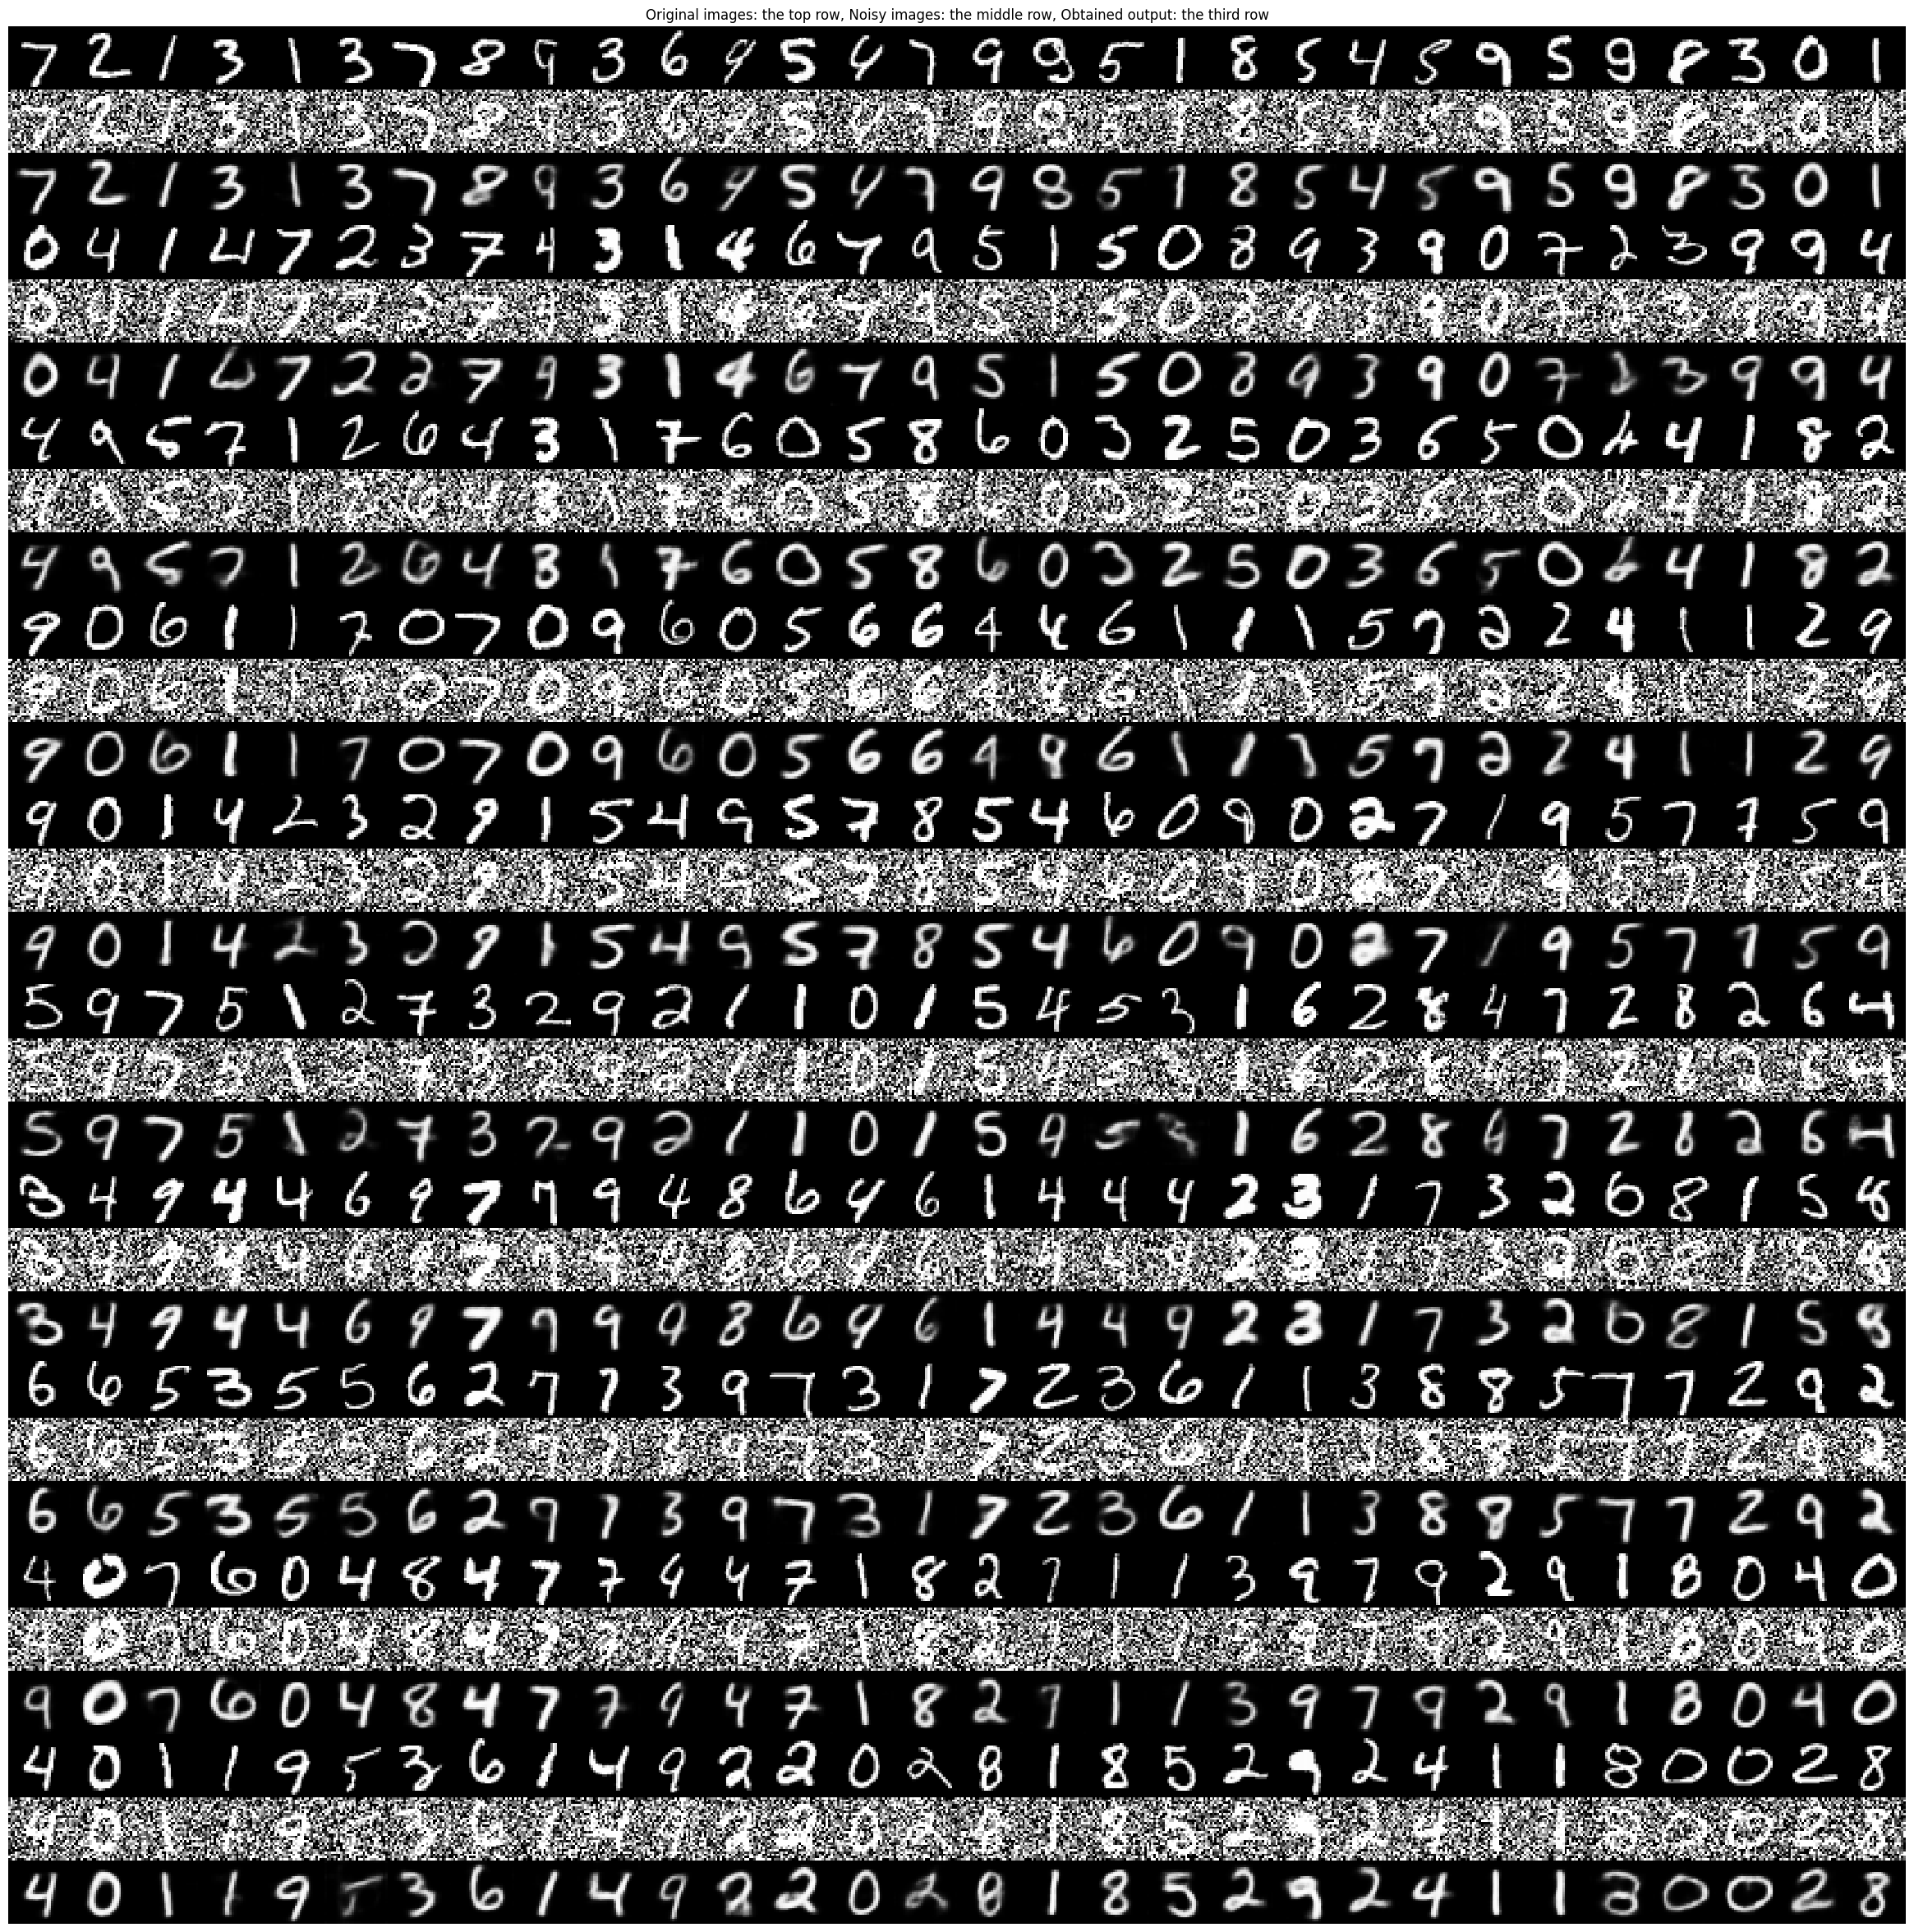

In [24]:
# We are preparing the panel for plotting the images
plt.figure(figsize=(30, 30))

# We extract 10x30 images
rows, cols = 10, 30
num = rows * cols

# We select the images: first the original ones, then the noisy ones, and then those generated by the autoencoder
imgs = np.concatenate([X_test[:num], X_test_noisy[:num], X_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))

# We organize the images such that they have the described shape
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)

plt.axis('off')
plt.title('Original images: the top row, '
          'Noisy images: the middle row, '
          'Obtained output: the third row')

# We are plotting the images
plt.imshow(imgs, interpolation='none', cmap='gray')

# We store the image generated in this way
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()